In [1]:
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from helper_functions import accuracy_fn
from torchsummary import summary
from safetensors.torch import save_model
import matplotlib.pyplot as plt
import cv2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transforms
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transforms
)

In [5]:
batch_size = 16

# put custom dataset to dataloader
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
# test if data can be inserted into dataloader
x, y = next(iter(train_dl))

### Model Creation

A Capsule Network (CapsNet) is a model that tries to improve from the cons of a normal CNN pipeline by avoiding max pooling which make it retain as much information as it can from a given image because max pooling creates a lossy pipeline

It has its own custom activation function, optimizer and loss:
- Activation Function: Squashing Function
- Optimizer: Routing
- Loss: Margin loss

The squashing function is defined as the following equation $$v_j=\frac{||s_j||^2}{1+||s_j||^2}\frac{s_j}{||s_j||}$$
where $v_j$ is the vector output from capsule $j$ with $s_j$ as its summed input

In [7]:
# squashing funcction
class Squash(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon # an epsilon is necessary to prevent the calculation dividing with zero
    
    def forward(self, x):
        sj_squared = (x**2).sum(dim=-1, keepdims=True)
        return (sj_squared / (1+ sj_squared)) * (x / torch.sqrt(sj_squared + self.epsilon))

The routing algorithm is used to optimize the values in the model through a voting-like system on which value is most optimal ($i$ is defined as the previous capsule and $j$ as the current capsule):
1. Modify $u_i$ to become $\hat{u}_{j|i}$ using a weight matrix $W$ such that $\hat{u}_{j|i}=W_{ij}u_i$
2. Create a zero tensor $b_{ij}$ with the same shape as $u$ to store logits.
3. Loop based on how many iterations defined for the following steps (the paper suggest 3 iterations generally)
4. Apply softmax to $b_{ij}$ with $k$ amount of classes where $c_{ij}=\frac{\exp(b_{ij})}{\sum_k\exp(b_{ik})}$
5. Summation of vectors $s_j=\sum_jc_{ij}\vec{u}_{j|i}$
6. Squash function $s_j$
7. Dot product $a_{ij}=v_j\cdot\vec{u}_{j|i}$
8. Update $b_{ij}$ to be $b_{ij}+a_{ij}$
9. Return $v_j$ once every iteration is completed

In [9]:
class Router(nn.Module):
    def __init__(self, in_caps, out_caps, in_d, out_d, iterations=3):
        super().__init__()
        self.in_caps = in_caps # no of capsules
        self.out_caps = out_caps # no of features per capsule
        self.iterations = iterations
        self.softmax = nn.Softmax(dim=1)
        self.squash = Squash()

        # weight matrix (maps capsules from lower layer to current layer)
        self.weight = nn.Parameter(torch.randn(in_caps, out_caps, in_d, out_d))

    def forward(self, u): # u's shape is (batch_size, n_capsules (in_caps), n_features (out_caps))
        u_hat = torch.einsum("ijnm,bin->bijm", self.weight, u)  # 1

        b = u.new_zeros(u.shape[0], self.in_caps, self.out_caps) # 2
        v = None # to be returned

        for i in range(self.iterations): # 3
            c = self.softmax(b) # 4
            s = torch.einsum("bij,bijm->bjm", c, u_hat) # 5
            v = self.squash(s) # 6
            a = torch.einsum("bjm,bijm->bij", v, u_hat) # 7
            b = b + a # 8
        
        return v # 9

Capsules need their own loss function in order to evaluate them with the Adam optimizer. It first calculates the length of each capsule which repersents the probability that class is present. Then it is put into the following loss function: $$L_k=T_k\max(0,m^+-||v_k||)^2+(1-T_k)\lambda\max(0,||v_k||-m^-)^2$$
where $T_k$ is 1 if class $k$ is present (only first part of equation is used) else $T_k$ is 0 if $k$ is not present (only second part of equation is used). $v_k$ is the squashed capsule from the routing algorithm of shape `[batch_size, n_labels, n_features]`. $\max(0,x)$ here is the same as $\text{ReLU}(x)$. $m^+,m^-$ are arbitrarily defined constants which are 0.9 and 0.1 respectively in the paper. $\lambda$ is used to stop overvaluing of capsule length during the first moments of training. This is set as 0.5 in the paper.

In [10]:
class MarginLoss(nn.Module):
    def __init__(self, n_labels, lamda = 0.5, m_pos = 0.9, m_neg = 0.1):
        super().__init__()
        self.n_labels = n_labels
        self.lamda = lamda
        self.m_pos = m_pos
        self.m_neg = m_neg

    def forward(self, v, labels):
        v_length = torch.sqrt((v**2).sum(dim=-1)) # capsule length
        labels = torch.eye(self.n_labels, device=device)[labels] # Tk

        # equation
        loss = labels * nn.functional.relu(self.m_pos - v_length) + (1 - labels) * self.lamda * nn.functional.relu(v_length - self.m_neg)

        return loss.sum(dim=-1).mean() # get mean result of all loss

With the algorithms and functions defined, we build the architecture of the model. Here is the first phase of the model:

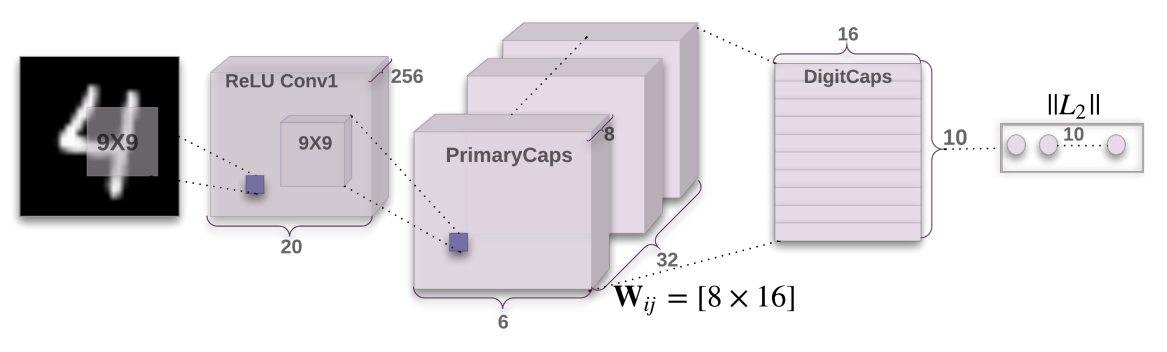

1. Input of shape `[batch_size, channels, width, height]` is fed into a convolutional layer that has 256 neurons with square kernel of size 9 and stride 1. This is then followed with a ReLU activation function.
2. A second convolutional layer of 32 channels and 8D (8 features) capsules totalling to 32*8=256 neurons wtih square kernel of size 9 and stride 2 is computed.
3. Resizing the output of the previous layer, we get the capsules
4. Squash capsules for normalization purposes
5. Undergo the routing algorithm (digit capsules)

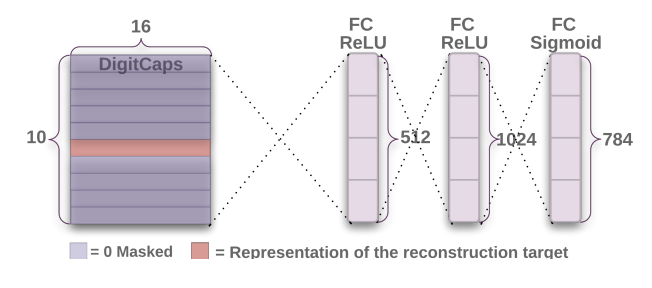

6. Get masks for reconstruction by getting the best prediction from the capsule (longest length)
7. Mask digit capsule with the capsule with the best prediction to make reconstruction with decoder
8. Reshape reconsutrction according to input size

In [22]:
class CapsNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 256, 9)
        self.conv2 = nn.Conv2d(256, 32*8, 9, 2)
        self.squash = Squash()

        self.dig_caps = Router(32 * 6 * 6, 10, 8, 16)

        self.decoder = nn.Sequential(
            nn.Linear(16*10, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x)) # 1
        x = self.conv2(x) # 2

        caps = x.view(x.shape[0], 8, 32 * 6 * 6).permute(0, 2, 1) # 3
        caps = self.squash(caps) # 4
        caps = self.dig_caps(caps) # 5

        with torch.no_grad():
            pred = (caps ** 2).sum(-1).argmax(-1) # 6
            mask = torch.eye(10, device=device)[pred] # 7

        reconstructions = self.decoder((caps * mask[:, :, None]).view(x.shape[0], -1)) # 7
        reconstructions = reconstructions.view(-1, 1, 28, 28) # 8

        return caps, reconstructions, pred

model = CapsNet().to(device)

Capsule networks have two ways of identifying loss: Predictions (margin loss) and reconstruction (MSE). 

In [36]:
margin_loss = MarginLoss(10) 
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

### Model Training

In [38]:
torch.manual_seed(20)

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(train_dl):

        X, y = X.to(device), y.to(device)

        # forward pass
        train_caps, train_reconstructions, train_pred = model(X)

        # metrics
        loss = margin_loss(train_caps, y) + 0.0005 * mse_loss(train_reconstructions, X)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=train_pred)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print metrics
    train_loss /= len(train_dl)
    train_acc /= len(train_dl)
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    
    # TESTING
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dl:

            X, y = X.to(device), y.to(device)


            # forward pass
            test_caps, test_reconstructions, test_pred = model(X)

            # metrics
            test_loss += margin_loss(test_caps, y) + 0.0005 * mse_loss(test_reconstructions, X)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)
        
        # print metrics
        test_loss /= len(test_dl)
        test_acc /= len(test_dl)
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------
Train Loss: 0.1347 | Train Accuracy: 95.04%


 20%|██        | 1/5 [01:00<04:03, 60.81s/it]

Test Loss: 0.0576 | Test Accuracy: 97.74%
Epoch: 1
------
Train Loss: 0.0480 | Train Accuracy: 98.11%


 40%|████      | 2/5 [02:01<03:02, 60.79s/it]

Test Loss: 0.0402 | Test Accuracy: 98.47%
Epoch: 2
------
Train Loss: 0.0320 | Train Accuracy: 98.67%


 60%|██████    | 3/5 [03:03<02:02, 61.31s/it]

Test Loss: 0.0298 | Test Accuracy: 98.94%
Epoch: 3
------
Train Loss: 0.0237 | Train Accuracy: 99.00%


 80%|████████  | 4/5 [04:05<01:01, 61.71s/it]

Test Loss: 0.0238 | Test Accuracy: 99.13%
Epoch: 4
------
Train Loss: 0.0184 | Train Accuracy: 99.24%


100%|██████████| 5/5 [05:07<00:00, 61.42s/it]

Test Loss: 0.0221 | Test Accuracy: 99.01%


In [39]:
save_model(model, "capsnet_mnist.safetensors")